In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os



#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMDB Non-Commercial Datasets
Subsets of IMDB data are available for access to customers for personal and non-commercial use. You can hold local copies of this data, and it is subject to our terms and conditions. Please refer to the [Non-Commercial Licensing](https://help.imdb.com/article/imdb/general-information/can-i-use-imdb-data-in-my-software/G5JTRESSHJBBHTGX?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=1ed1aea6-d2ad-4705-95fd-ba13f1b5014f&pf_rd_r=XRE3QWF2G5YWTD2SGT0V&pf_rd_s=center-1&pf_rd_t=60601&pf_rd_i=interfaces&ref_=fea_mn_lk1) and [copyright/license](http://www.imdb.com/Copyright?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=1ed1aea6-d2ad-4705-95fd-ba13f1b5014f&pf_rd_r=XRE3QWF2G5YWTD2SGT0V&pf_rd_s=center-1&pf_rd_t=60601&pf_rd_i=interfaces&ref_=fea_mn_lk2) and verify compliance.

# Data Location
The dataset files can be accessed and downloaded from https://datasets.imdbws.com/. The data is refreshed daily.

# IMDb Dataset Details
Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name.

In [2]:
#main media name dataset
tbasics_file = "/kaggle/input/imdb-basic-dataset/title.basics.tsv/data.tsv"
# TV show link table
eposode_file = "/kaggle/input/imdb-basic-dataset/title.episode.tsv/data.tsv"
# Big file, a linking dataset for film workers/acters to videos.  also lists jobs, category
principals_file = "/kaggle/input/imdb-basic-dataset/title.principals.tsv/data.tsv"
# ratings
ratings_file = "/kaggle/input/imdb-basic-dataset/title.ratings.tsv/data.tsv"
# Actors, Workers, people in credits
nbasics_file = "/kaggle/input/imdb-basic-dataset/name.basics.tsv/data.tsv"
# very big file; alternative names for movies. 
#  some Japanese or Chinese moves have different titles in different regions
#  ie - Shogun Assassian (US) and Lone Wolf and Cub (JP)
akas_file = "/kaggle/input/imdb-basic-dataset/title.akas.tsv/data.tsv"
# link dataset for media to directors and writers
crew_file = "/kaggle/input/imdb-basic-dataset/title.crew.tsv/data.tsv"

# IMDB Python Class

this will contain the logic for dealing with the IMDB data.

In [3]:
class IMDB:
    def __init__(self, tbasic, ratings):
        basics = pd.read_csv(tbasic, sep='\t', low_memory=False)
        ratings = pd.read_csv(ratings, sep='\t')
        self.tbasics = basics.join(ratings.set_index('tconst'), on="tconst").replace('\\N', np.nan)
        self.genres = []
        self.Videos = None
        self.TVShow = None

    def find_video(self, col, match):
        return self.Videos[col].str.contains(match).sum()

    def find_tv(self, col, match):
        return self.TVShow[col].str.contains(match).sum()

    def find_video_df(self, match):
        return None

    def find_tv_df(self, match):
        return None

    def titleTypeCount(self):
        return self.tbasics.groupby(['titleType']).titleType.count()

    def genres_imdb(self):
        if self.TVShow is not None:
            return self.TVShow.groupby(['genres']).titleType.count()
        elif self.Videos is not None:
            return self.Videos.groupby(['genres']).titleType.count()
        else:
            return self.tbasics.groupby(['genres']).titleType.count()

    # returns a count of each genre found
    def set_genres(self):
        cg = {}
        # reset
        self.genres = []
        if self.TVShow is not None:
            data = self.TVShow.genres.dropna()
        elif self.Videos is not None:
            data = self.Videos.genres.dropna()
        else:
            data = self.tbasics.genres.dropna()
        for x in data:
            for g in self.process_genres(x):
                if g not in self.genres:
                    self.genres.append(g)
                    cg[g] = 1
                else:
                    cg[g] = cg[g] + 1
        return cg

    def process_genres(self, g):
        return str(g).split(',')

    # Filter out the TV shows and episodes.

    def filter_tv(self):
        self.Videos = self.tbasics.loc[
            (self.tbasics['titleType'] != "tvSeries") & (self.tbasics['titleType'] != "tvEpisode")
        ].rename(columns={
            "startYear": "year",
            "runtimeMinutes":"minutes"
        }).drop(["endYear"], axis=1)

    def set_tvshows(self, episodes):
        # set \\N to zero hear since some TV databases have shows with season 0 and episode 0 for some specials
        e = pd.read_csv(episodes, sep='\t').rename(columns={
            "seasonNumber": "S",
            "episodeNumber": "E"
        }).replace('\\N', 0)

        self.TVShow = e.join(self.tbasics.drop([
            'isAdult',
            'runtimeMinutes',
            'genres',
            'titleType',
            'averageRating',
            'numVotes'
        ], axis=1).rename(columns={
            "tconst": "parentTconst",
            "primaryTitle": "TVShow"
        }).set_index('parentTconst'), on="parentTconst").join(self.tbasics.drop([
            "endYear"
        ], axis=1).rename(columns={
            "primaryTitle": "episodeTitle",
            "originalTitle": "originalEpisode",
            "startYear": "year",
            "runtimeMinutes": "minutes"
        }).set_index('tconst'), on="tconst").drop([
            'parentTconst'
        ], axis=1)




    # Get DataFrame filtered to titleType in the IMDB dataset
    # some videos/movies might have a title type you might not expect, like video instead of movie
    def get_tvMiniSeries(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvMiniSeries")]

    def get_tvSpecial(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvSpecial")]

    def get_tvPilot(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvPilot")]

    def get_video(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "video")]

    def get_tvPilot(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "videoGame")]

    # movies
    def get_tvMovie(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvMovie")]

    def get_movie(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "movie")]

    # shorts
    def get_tvShort(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "tvShort")]

    def get_short(self):
        return self.tbasics.loc[(self.tbasics['titleType'] == "short")]

# Loaded the Media names and ratings dataset

In [4]:
IM = IMDB(tbasics_file, ratings_file)


# make Year an integer value

In [5]:
IM.tbasics['startYear'] = pd.to_numeric(IM.tbasics['startYear'], downcast="integer")
IM.tbasics['endYear'] = pd.to_numeric(IM.tbasics['endYear'], downcast="integer")
#IM.tbasics['runtimeMinutes'] = pd.to_numeric(IM.tbasics['runtimeMinutes'], downcast="integer")
#IM.tbasics

# Build TV show DataFrame

In [6]:
IM.set_tvshows(eposode_file)

# Build the Videos DataFrame without TV Shows

In [7]:
IM.filter_tv()
# IM.Videos

# Lets look at the ratings of Star Wars
I was 5-6 when I first saw a New Hope and Empire Strikes Back.  I also read a lot of the legacy books when I was in grade 8.  lots of memories

In [8]:
SW = IM.Videos.loc[ IM.Videos["primaryTitle"].str.contains("Star Wars") & (IM.Videos['titleType'] == 'movie') & (IM.Videos['numVotes'] > 1024)].dropna().drop(columns=['titleType', 'originalTitle', 'isAdult']).sort_values(by='year')
#SW['year'] = pd.to_numeric(SW['year'], downcast="integer")
SW

,tconst,primaryTitle,year,minutes,genres,averageRating,numVotes
75150,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,121,"Action,Adventure,Fantasy",8.6,1395759.0
78966,tt0080684,Star Wars: Episode V - The Empire Strikes Back,1980.0,124,"Action,Adventure,Fantasy",8.7,1323423.0
84310,tt0086190,Star Wars: Episode VI - Return of the Jedi,1983.0,131,"Action,Adventure,Fantasy",8.3,1079320.0
117973,tt0120915,Star Wars: Episode I - The Phantom Menace,1999.0,136,"Action,Adventure,Fantasy",6.5,825987.0
118695,tt0121765,Star Wars: Episode II - Attack of the Clones,2002.0,142,"Action,Adventure,Fantasy",6.6,730618.0
118696,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005.0,140,"Action,Adventure,Fantasy",7.6,813140.0
2000701,tt1185834,Star Wars: The Clone Wars,2008.0,98,"Action,Adventure,Animation",5.9,69306.0
6137501,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.8,948346.0
7146268,tt3748528,Rogue One: A Star Wars Story,2016.0,133,"Action,Adventure,Sci-Fi",7.8,658838.0
6168620,tt2527336,Star Wars: Episode VIII - The Last Jedi,2017.0,152,"Action,Adventure,Fantasy",6.9,648706.0


# lets look at the Average Rating

My favorate Star Wars movie is Revenge of the Sith, it's IMDB rating is 7.6.  

My least favorate star wars movies are Last Jedi and The Rise of Skywalker, their IMDB ratings are 6.9 and 6.5.

Empire Strikes Back has the highest average rating, then A New Hope and Return of the Jedi -- these are Classics!

The Lowest rating is for the Clone Wars cartoon movie.  I thought it was a good, but the votes in this dataset are low compaired to the other Movies and so is the Average rating of 5.9.

<Axes: xlabel='Star Wars Movie Ratings'>

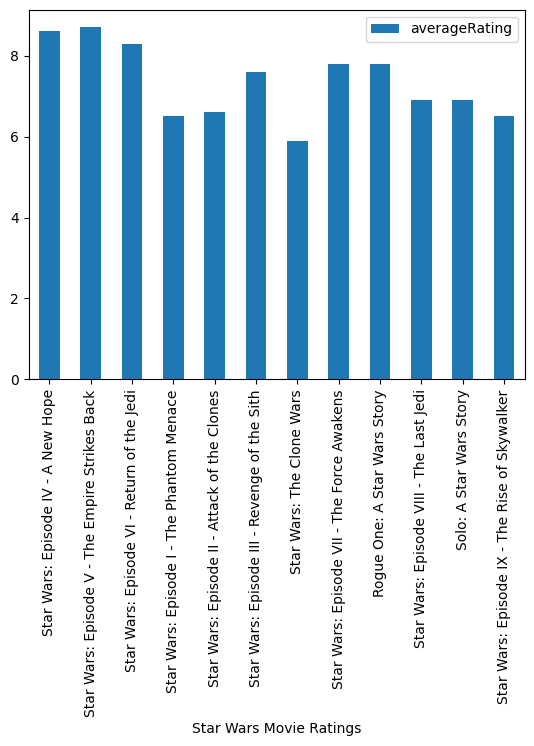

In [9]:
SW.plot.bar(x='primaryTitle', y='averageRating', xlabel="Star Wars Movie Ratings")

# Number of Votes

<Axes: xlabel='Votes for Star Wars Movies'>

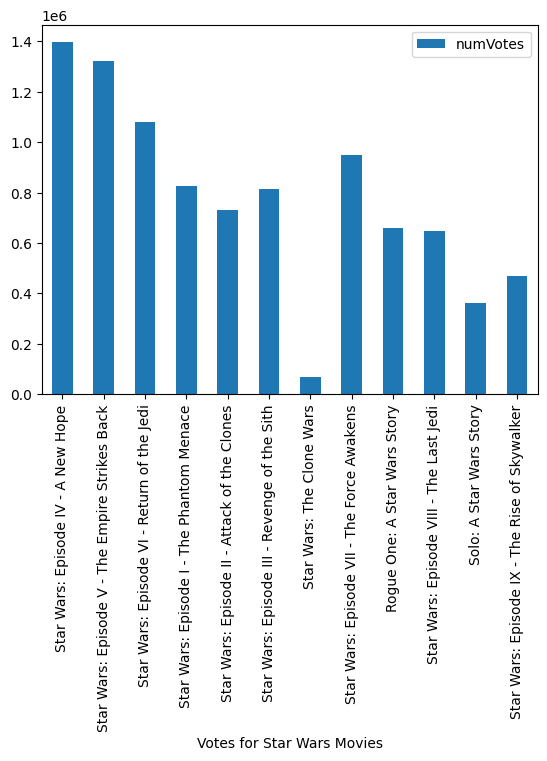

In [10]:
SW.plot.bar(x='primaryTitle', y='numVotes', xlabel="Votes for Star Wars Movies")

# Scater Plot of Average Rating to number of votes over the years

<Axes: title={'center': 'How did the average rating of Star Wars change over the years?\n\n'}, xlabel='year', ylabel='numVotes'>

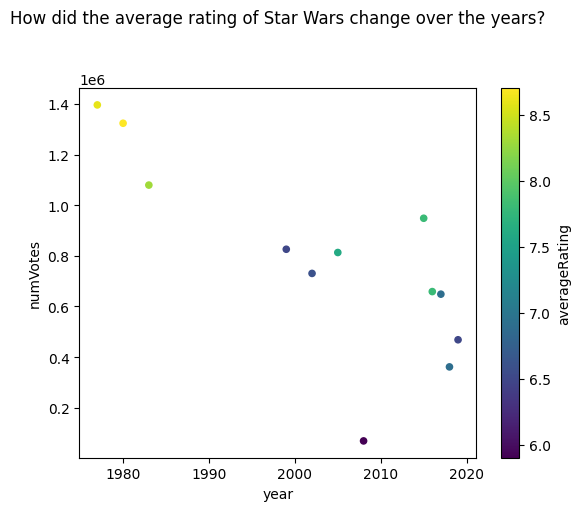

In [11]:
SW.plot.scatter(title="How did the average rating of Star Wars change over the years?\n\n",
                x='year',
                      y='numVotes',
                      c='averageRating',
                      colormap='viridis'    
               )

# Pie chart of Average Rating

based on this visualization, the distribution looks fairly even; it's between 5.9 to 8.7 for the average rating.

<Axes: title={'center': 'Average Rating'}>

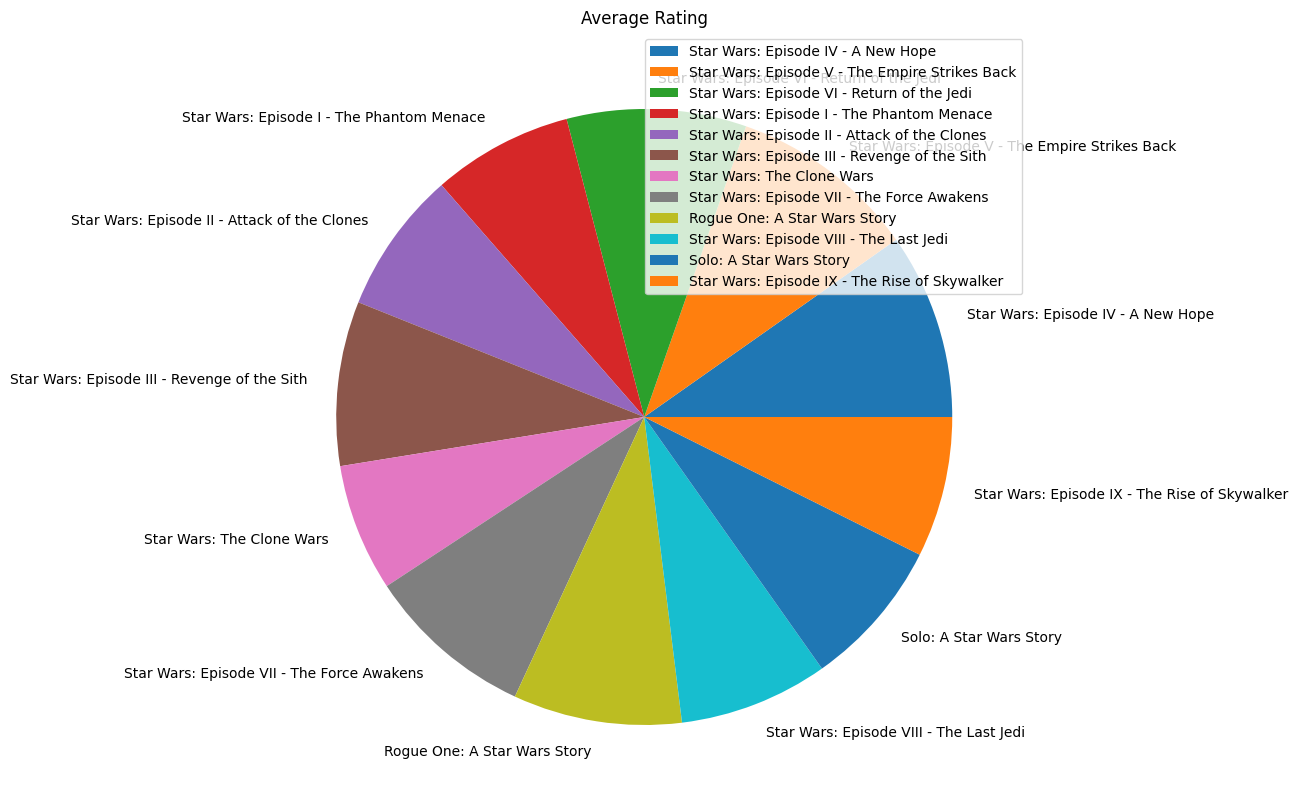

In [12]:
SW.set_index('primaryTitle').plot.pie(y='averageRating', figsize=(10, 10), title='Average Rating', ylabel='')

# Pie Chart of vote counts for each movies

now with this chart you can see how the votes are distributed, The Clone Wars got the least votes and has the smallest piece of the pie.  
A New Hope and Empire Strikes Back have the most votes.

<Axes: title={'center': 'Number of Votes'}>

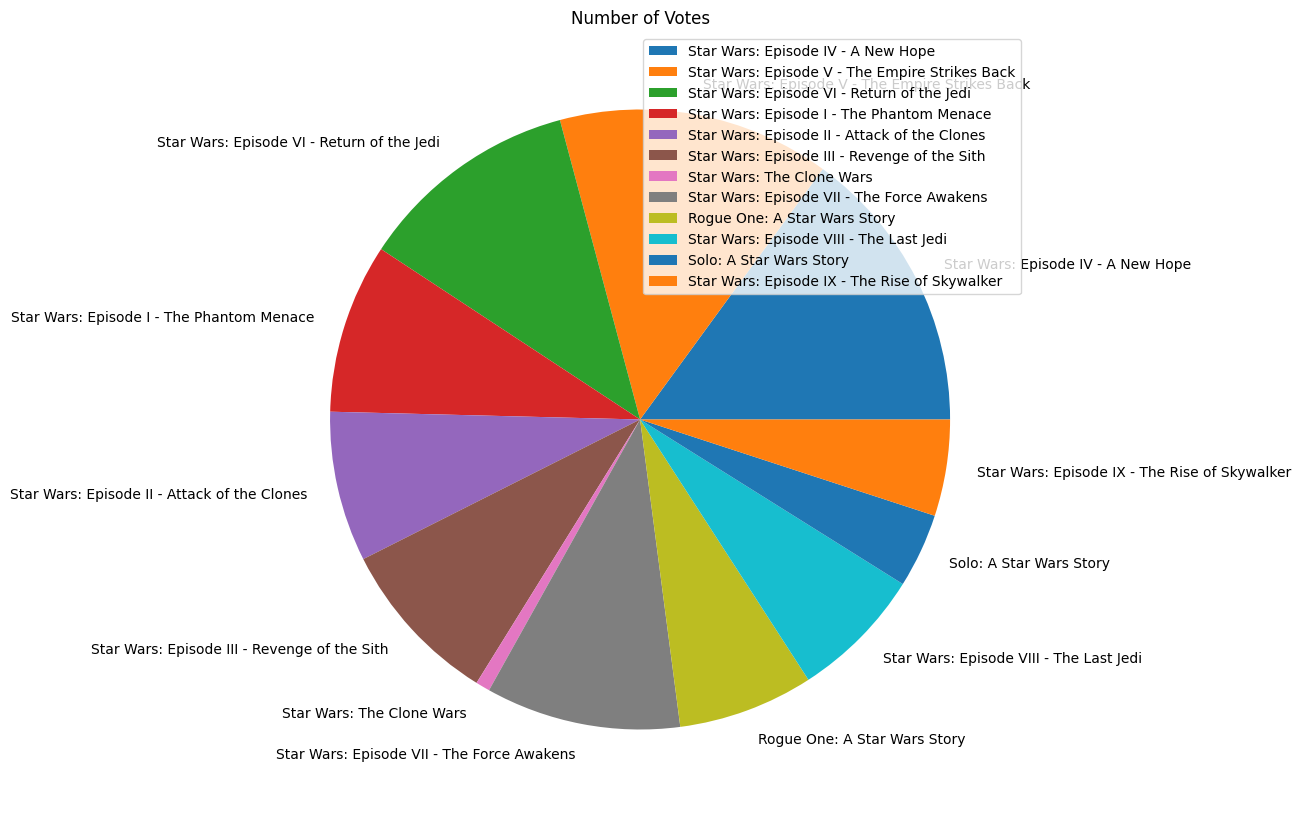

In [13]:
SW.set_index('primaryTitle').plot.pie(y='numVotes', figsize=(10, 15), title='Number of Votes', ylabel='')

<Axes: title={'center': 'Star Wars Average Rating over the years'}, xlabel='year', ylabel='averageRating'>

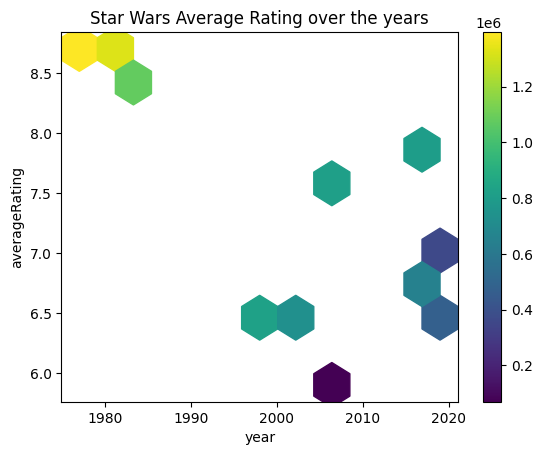

In [14]:

SW.plot.hexbin(x='year',
                    y='averageRating',
                    C='numVotes',
                    #reduce_C_function=np.sum,
                    gridsize=10,
                    cmap="viridis", title="Star Wars Average Rating over the years"
               )

In [15]:
SWTV = IM.TVShow.loc[ IM.TVShow["TVShow"].str.contains("Star Wars|The Book of Boba Fett|Mandalorian|Ahsoka|Andor|Obi-Wan Kenobi", regex=True)].dropna().drop(columns=['titleType', 'originalTitle', 'isAdult', "year","originalEpisode", "genres"]).sort_values(by='startYear')
#SWTV['startYear'] = pd.to_numeric(SWTV['startYear'], downcast="integer")
SWTV

,tconst,S,E,TVShow,startYear,endYear,episodeTitle,minutes,averageRating,numVotes
304362,tt0814126,2,1,Star Wars: Droids,1985.0,1986.0,The Great Heep,48,6.0,270.0
318606,tt0837309,1,1,Star Wars: Droids,1985.0,1986.0,The White Witch,23,5.8,178.0
318604,tt0837307,1,11,Star Wars: Droids,1985.0,1986.0,The Roon Games,23,6.3,116.0
318603,tt0837306,1,8,Star Wars: Droids,1985.0,1986.0,The Revenge of Kybo Ren,23,5.8,127.0
318602,tt0837305,1,7,Star Wars: Droids,1985.0,1986.0,The Pirates of Tarnoonga,23,5.9,125.0
...,...,...,...,...,...,...,...,...,...,...
2167114,tt13840902,1,4,Obi-Wan Kenobi,2022.0,2022.0,Part IV,36,6.4,20242.0
2167081,tt13840822,1,3,Obi-Wan Kenobi,2022.0,2022.0,Part III,45,7.6,24300.0
2157881,tt13820658,1,2,Obi-Wan Kenobi,2022.0,2022.0,Part II,39,7.3,24000.0
2077169,tt13636426,1,1,Obi-Wan Kenobi,2022.0,2022.0,Part I,53,7.4,24948.0


# What is the trend of Star Wars TV Shows?
im going to plot all the TV shows that have Star Wars in the TV show title.  this will look at the ratings by year and color the values based on votes for each entry.

<Axes: title={'center': 'Star Wars TV Shows Average Rating over the years'}, xlabel='startYear', ylabel='averageRating'>

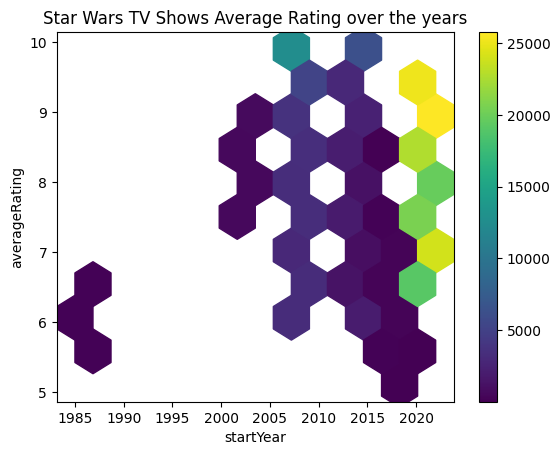

In [16]:
SWTV.plot.hexbin(x='startYear',
                    y='averageRating',
                    C='numVotes',
                   # reduce_C_function=np.sum,
                    gridsize=10,
                    cmap="viridis", title="Star Wars TV Shows Average Rating over the years"
               )

In [17]:
ep = SWTV.groupby('TVShow').E.count()
#mins = SWTV.groupby('TVShow').minutes.sum()
rate = SWTV.groupby('TVShow').averageRating.sum()
votes = SWTV.groupby('TVShow').numVotes.sum()

enum = pd.DataFrame(ep)
#enum['minutes'] = mins
enum['averageRating'] = rate / enum['E']
enum['numVotes'] = votes / enum['E']
enum = enum.reset_index()

In [18]:
enum

,TVShow,E,averageRating,numVotes
0,LEGO Star Wars: The Resistance Rises,5,6.440000,49.400000
1,Lego Star Wars: All-Stars,6,7.116667,41.666667
2,Lego Star Wars: Droid Tales,5,7.480000,105.600000
3,Lego Star Wars: The Freemaker Adventures,26,7.676923,81.346154
4,Lego Star Wars: The Yoda Chronicles,9,7.066667,210.888889
5,Obi-Wan Kenobi,6,7.500000,22768.333333
6,Star Wars Resistance,50,6.378000,349.360000
7,Star Wars: Clone Wars,25,8.000000,598.400000
8,Star Wars: Droids,14,6.085714,140.285714
9,Star Wars: Forces of Destiny,35,6.214286,211.914286


<Axes: title={'center': 'Star Wars Episode count'}, xlabel='TVShow'>

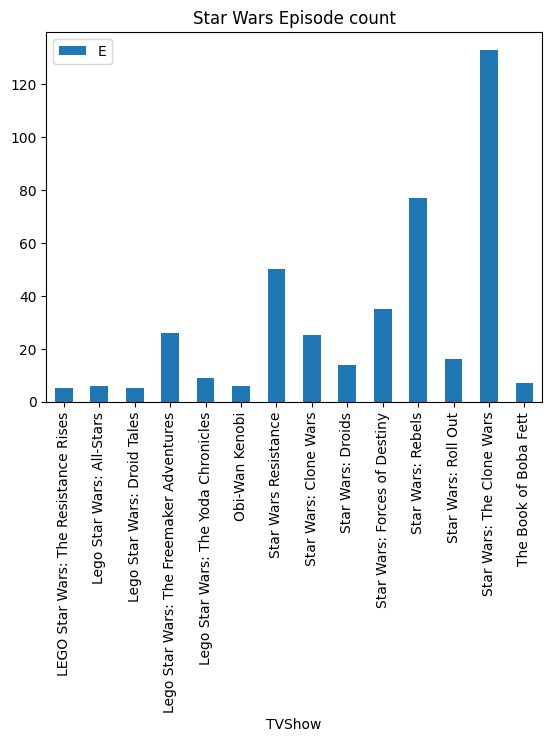

In [19]:
enum.plot.bar(x="TVShow", y="E", title="Star Wars Episode count")